In [ ]:
# Dalle Flow

In [ ]:
!pip install "docarray[common]>=0.13.5"

In [8]:
!pip install "docarray[common]>=0.13.5"

zsh:1: no matches found: docarray[common]


In [6]:
from docarray import Document

In [7]:
server_url = 'grpc://demo-cas.jina.ai:51005'

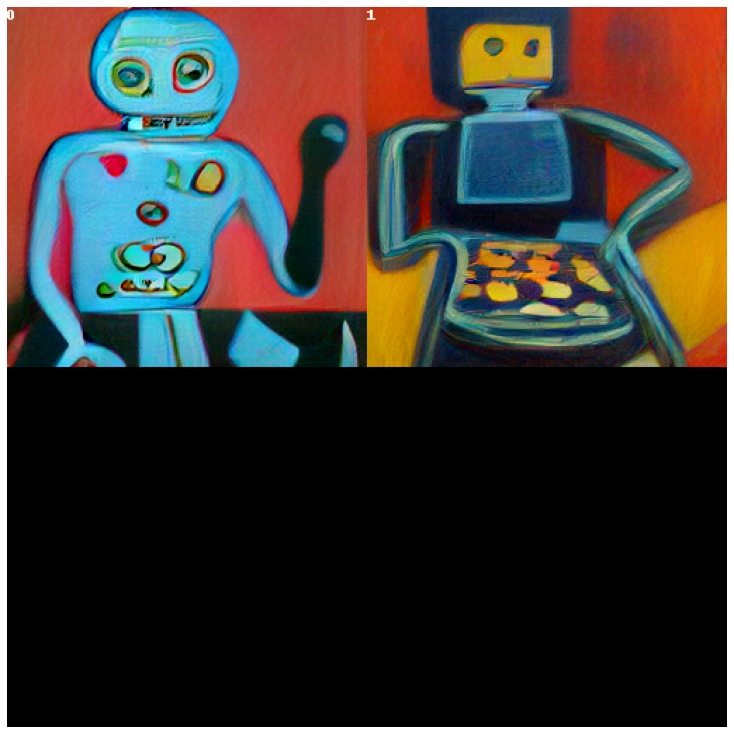

CPU times: user 392 ms, sys: 41.4 ms, total: 433 ms
Wall time: 23.2 s


In [10]:
%%time

prompt = 'an oil painting of a humanoid robot playing chess in the style of Matisse'

da = Document(text=prompt).post(server_url, parameters={'num_images': 2}).matches

da.plot_image_sprites(fig_size=(10,10), show_index=True)

In [18]:
fav_id = 0

da[fav_id].display()

In [19]:
%%time

diffused = da[fav_id].post(f'{server_url}/diffuse', parameters={'skip_rate': 0.2}).matches

diffused.plot_image_sprites(fig_size=(10,10), show_index=True)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /Users/hanxiao/.pyenv/versions/3.7.9/lib/python3.7/site-packages/IPython/core/magics/exec │
│ ution.py:1329 in time                                                                     │
│                                                                                           │
│   1326 │   │   │   │   # multi-line %%time case                                           │
│   1327 │   │   │   │   if expr_val is not None:                                           │
│   1328 │   │   │   │   │   code_2 = self.shell.compile(expr_val, source, 'eval')          │
│ ❱ 1329 │   │   │   │   │   out = eval(code_2, glob, local_ns)                             │
│   1330 │   │   │   except:                                                                │
│   1331 │   │   │   │   self.shell.showtraceback()                                         │
│   1332 │   │   │   │   return                                                             │
│ <timed exec>:3 in <module>                                                                │
│                                                                                           │
│ /Users/hanxiao/Documents/docarray/docarray/array/mixins/plot.py:337 in plot_image_sprites │
│                                                                                           │
│   334 │   │   :param show_progress: show a progresbar.                                    │
│   335 │   │   """                                                                         │
│   336 │   │   if not self:                                                                │
│ ❱ 337 │   │   │   raise ValueError(f'{self!r} is empty')                                  │
│   338 │   │                                                                               │
│   339 │   │   import matplotlib.pyplot as plt                                             │
│   340                                                                                     │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: <DocumentArray (length=0) at 5129566352> is empty

In [143]:
dfav_id = 24

diffused[dfav_id].display()

In [144]:
%%time

diffused[dfav_id].post(f'{server_url}/upscale').display()

CPU times: user 78.7 ms, sys: 56.2 ms, total: 135 ms
Wall time: 6.75 s
